# Stock Prediction using LSTM, RNN, and Tensorflow

In [23]:
# If never previously used the following python libraries, run the following cell to install them before importing*
# pip install pandas
# pip install matplotlib
# pip install tensorflow
# pip install seaborn
# pip install scikit-learn

## [1] import necessary libaries

In [24]:
# pandas            used for data manipulation (load, clean, reshape, and perform calculations) and analysis on data
# numpy             numerical computations, mathematical functions, and linear algebra for multidimensional array math
# datetime          format, extract components, and perform calculations related to time

# matplotlib        library for creating static, animated, and interactive visualizations
# seaborn           creating visualizations

# tensorflow        tool owned by Google for building neural networks, data pipelines, and deploying models
# keras             API built into TensorFlow which streamlines the process of defining layers, training, and evaluating neural networks
# scikit-learn      toolkit of efficient and user-friendly algorithms and tools for various machine learning tasks

# os                for file/directory operations, environment variables, etc.
# warnings          manages warnings

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
import seaborn as sns
import os
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings("ignore")

# [2] read in the CSV containing stock data

In [26]:
goog = pd.read_csv('./GOOG.csv')
print(goog.head(4))
goog.info()

         Date      Open      High       Low     Close  Adj Close     Volume
0  2004-08-19  2.490664  2.591785  2.390042  2.499133   2.499133  897427216
1  2004-08-20  2.515820  2.716817  2.503118  2.697639   2.697639  458857488
2  2004-08-23  2.758411  2.826406  2.716070  2.724787   2.724787  366857939
3  2004-08-24  2.770615  2.779581  2.579581  2.611960   2.611960  306396159
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4858 entries, 0 to 4857
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       4858 non-null   object 
 1   Open       4858 non-null   float64
 2   High       4858 non-null   float64
 3   Low        4858 non-null   float64
 4   Close      4858 non-null   float64
 5   Adj Close  4858 non-null   float64
 6   Volume     4858 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 265.8+ KB


# [3] prepare data by converting to proper data types
Any kind of date or time feature (a column containing those values) should always be in the `DateTime` data type

In [27]:
goog.columns = [x.lower() for x in goog.columns]
goog['date'] = pd.to_datetime(goog['date'])
goog.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4858 entries, 0 to 4857
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       4858 non-null   datetime64[ns]
 1   open       4858 non-null   float64       
 2   high       4858 non-null   float64       
 3   low        4858 non-null   float64       
 4   close      4858 non-null   float64       
 5   adj close  4858 non-null   float64       
 6   volume     4858 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 265.8 KB


# [4] create stacked line plot graphs visualizing open, close stock prices 

Text(0, 0.5, 'Price per Stock')

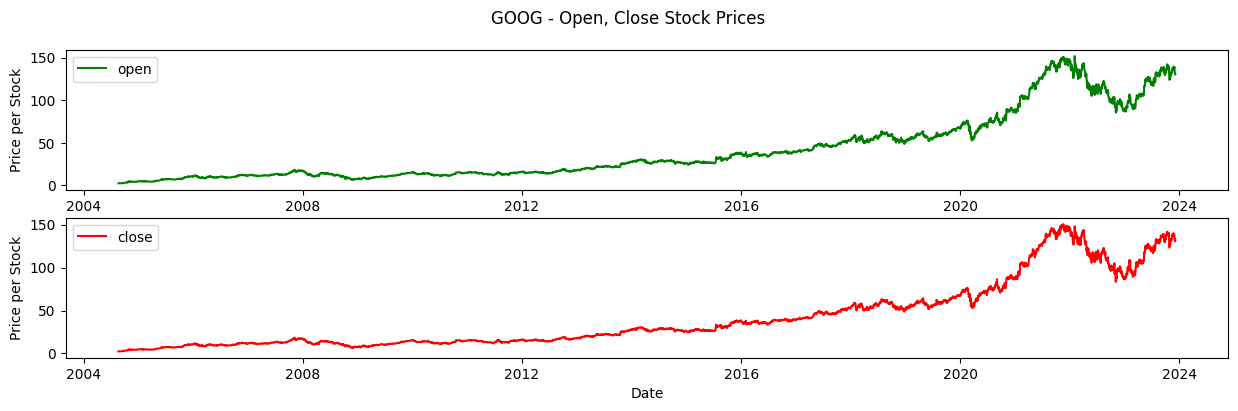

In [28]:
fig, axs = plt.subplots(2, figsize=(15, 4))
fig.suptitle('GOOG - Open, Close Stock Prices')

axs[0].plot(goog['date'], goog['open'], label="open", color='green')
axs[0].legend()

axs[0].set_xlabel('Date')
axs[0].set_ylabel('Price per Stock')


axs[1].plot(goog['date'], goog['close'], label="close", color='red')
axs[1].legend()

axs[1].set_xlabel('Date')
axs[1].set_ylabel('Price per Stock')

# [5] plot volume of trade data

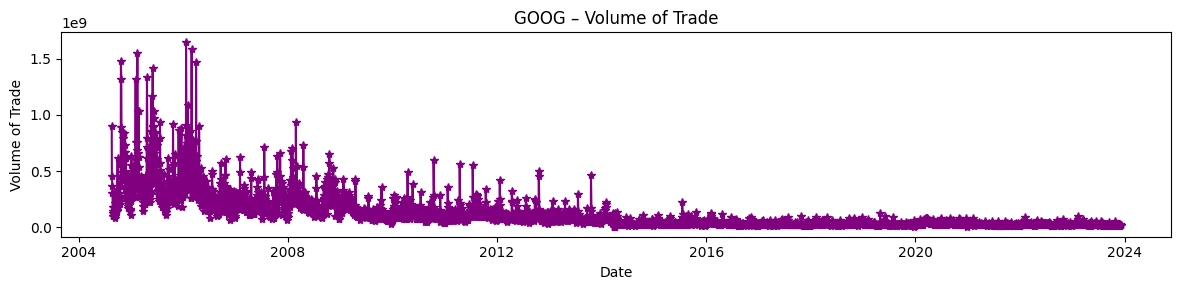

In [29]:
plt.figure(figsize=(12, 3))

plt.plot(goog['date'], goog['volume'], color='purple', marker='*')
plt.title("GOOG – Volume of Trade")

plt.xlabel("Date")
plt.ylabel("Volume of Trade")
plt.tight_layout()

# [6] narrow date range for stock prices between 2013 and 2018

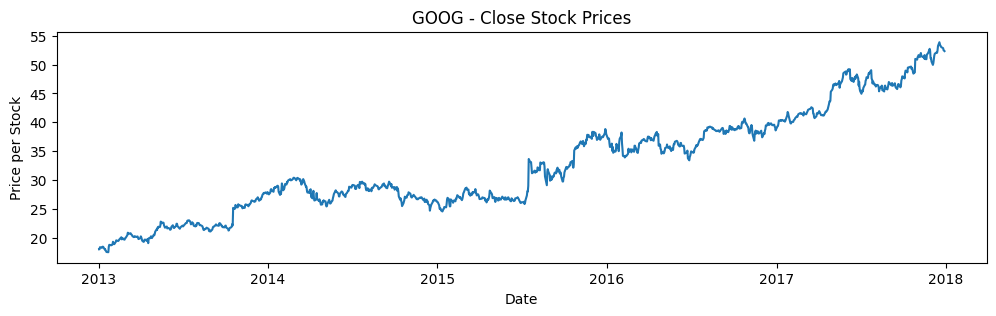

In [30]:
plt.figure(figsize=(12, 3))
prediction_range = goog.loc[(goog['date'] > datetime(2013,1,1)) & (goog['date']<datetime(2018,1,1))]

plt.plot(prediction_range["date"], prediction_range['close'])
plt.xlabel("Date")
plt.ylabel("Price per Stock")
plt.title("GOOG - Close Stock Prices")
plt.show()

# [7] select subset of data to allocate for training
One part of the inequal data split will be used for training data, the other part will be used for data validation part as well.

In [31]:
# get a subset of data (only need data points for close prices)
close_prices = goog.filter(['close'])
close_df = close_prices.values

# partition dataset into an 80% / 20% split
training_data_count = int(np.ceil(len(close_df) * .80))
validation_data_count = len(close_df)-training_data_count
print(training_data_count, "/", validation_data_count)

3887 / 971


# [8] scale and transform data between range of 0 and 1
Applying scaling and preparing `training_data` features helps the model to learn and prevents outliers from messing up the process.

`MinMaxScaler` doesn't reduce the effect of outliers, but it linearly scales them down into a fixed range, where the largest occurring data point corresponds to the maximum value and the smallest one corresponds to the minimum value.

In [32]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(close_df)

print(scaled_data)
scaled_training_data = scaled_data[0:int(training_data_count), :]

[[5.54588186e-05]
 [1.39474206e-03]
 [1.57790459e-03]
 ...
 [8.82679683e-01]
 [8.64530737e-01]
 [8.76405091e-01]]


# [9] set `x_train` and `y_train` data

Train your model on one set of data (`x_train` and `y_train`), and then evaluate its performance on unseen data (`x_test` and `y_test`). This helps prevent overfitting and gives you a more honest assessment of how model will perform in the real world.

* The `x_train` data represents the input features and includes all independent variables that will be used to train the model. These are the attributes your model uses to make predictions.
* The `y_train` represents the target values or dependent variable -  the thing you're trying to predict. This is what the model tries to learn the relationship between from the features (`x_train`).

In [33]:
x_train = []
y_train = []

print(len(scaled_training_data))

# for loop which prepares feature set (x_train) using a 60-step window of past data to predict the next value and prepares target values. essentially each (x_train) sample represents 60 previous timesteps as features, and the corresponding (y_train) value is the target value to be predicted at the next timestep.
for i in range(60, len(scaled_training_data)):
	x_train.append(scaled_training_data[i-60:i, 0])
	y_train.append(scaled_training_data[i, 0])

# print(x_train)
# print(x_train[1])
# print(len(x_train[0]))
# print(x_train[0][0])
# print(len(x_train))	

3887


# [10] reshape training data for RNN, LSTM
RNNs and LSTMs require input in multidimensional shapes. The `np.shape()` command changes the shape to (x, y, 1). The data wlll still have the same data but now it's arranged differently:
* `x` number of samples
* `y` Each sample is a y-element sequence
* `1` Each element in the sequence is treated as a single-channel "image" (hence the added dimension of 1)

In [34]:
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
print(x_train.shape)
print(y_train.shape)	

(3827, 60, 1)
(3827,)


# [11] build gated RNN, LSTM network using Tensorflow `keras`
Using TensorFlow, we can easily create LSTM-gated RNN cells. 
**Long Short Term Memory (LSTM)** is used in **Recurrent Neural Networks (RNN)** for creating sequence models and time series data. LSTM is used to avoid the vanishing gradient issue which is widely occurred in training RNN. 
* **Gradient Propagation**: During training, gradients (calculations of how much to adjust model weights to improve accuracy) are calculated and propagated backward through the network in a process called backpropagation. These gradients are essential for updating the network's weights.
* **Vanishing Gradients**: In deep networks, gradients can become progressively smaller as they move backward through the layers. In extreme cases, when gradients become very close to zero, earlier layers may receive little to no learning signal, hindering their ability to update weights and effectively learn.

To stack multiple LSTM in TensorFlow it is mandatory to use `return_sequences = True`. Since our data is time series varying we apply no activation to the output layer and it remains as 1 node. 

In [35]:
# STEP 1: initialize a Sequential model in Keras
model = keras.models.Sequential()

# STEP 2: add an LSTM layer with 64 units (neurons), tell the layer to output a sequence at each timestep rather than a single output, and then defines the expected input shape for EACH timestep in your data.
model.add(keras.layers.LSTM(units=64,
                            return_sequences=True,
                            input_shape=(x_train.shape[1], 1)))

# STEP 3: add another LSTM layer with 64 units
model.add(keras.layers.LSTM(units=64))

# STEP 4: add a dense, fully connected layer with 32 units
model.add(keras.layers.Dense(32))

# STEP 5: randomly "drops" 50% of the units during training to prevent overfitting
model.add(keras.layers.Dropout(0.5))

# STEP 6: a dense layer with a single unit, likely indicating the model is designed for regression – predicting a single numerical value
model.add(keras.layers.Dense(1))

# STEP 7: print a model summary, showing the layers, their output shapes, and the number of trainable parameters
model.summary


<bound method Model.summary of <keras.src.engine.sequential.Sequential object at 0x30f762b20>>

# [12] optimize loss function using gradient descent
* `optimizer="adam"` specifies that you want to use the Adam optimization algorithm. Adam is a popular and efficient algorithm for updating the weights of your model during training to minimize the error/loss
* `loss='mean_squared_error'` defines the loss function that your model will try to minimize to monitor whether the model is improving with training or not. `'Mean_squared_error'` is a common loss function used for regression problems, where the model predicts continuous numerical values

In [36]:
# prepares (compiles) your machine learning model for the training process
model.compile(optimizer='adam',
			loss='mean_squared_error')

# method that starts the actual training process on your model
history = model.fit(x_train,
					y_train,
					epochs=10)

# x_train – training data containing the features your model will learn from
# y_train – target labels or values associated with your training data that your model tries to learn how to predict these values
# epochs=10 - determines the number of iterations (cycles) the model will go through the entire training dataset. One epoch means the model has seen all of your training data once

Epoch 1/10
120/120 [==============================] - 5s 28ms/step - loss: 0.0022
Epoch 2/10
120/120 [==============================] - 3s 29ms/step - loss: 0.0010
Epoch 3/10
120/120 [==============================] - 3s 29ms/step - loss: 8.4907e-04
Epoch 4/10
120/120 [==============================] - 3s 29ms/step - loss: 8.0165e-04
Epoch 5/10
120/120 [==============================] - 4s 29ms/step - loss: 6.5808e-04
Epoch 6/10
120/120 [==============================] - 4s 30ms/step - loss: 5.8140e-04
Epoch 7/10
120/120 [==============================] - 4s 29ms/step - loss: 5.2806e-04
Epoch 8/10
120/120 [==============================] - 4s 30ms/step - loss: 4.8550e-04
Epoch 9/10
120/120 [==============================] - 4s 30ms/step - loss: 4.8649e-04
Epoch 10/10
120/120 [==============================] - 4s 29ms/step - loss: 5.2478e-04


# [13] creating test date for model prediction

In [37]:
# subtracts 60 from the training_data_count which calculates starting index for the test data, while the ":" selects all columns in the sliced range, effectively creating a test dataset using the last rows of the scaled_data.
test_data = scaled_data[training_data_count - 60:, :]

# x_test - remaining portion of the independent variables from the data which will not be used in the training phase and will be used to make predictions to test the accuracy of the model.
x_test = []
for i in range(60, len(test_data)):
	x_test.append(test_data[i-60:i, 0])
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# y_test - This data has category labels for your test data 
y_test = close_df[training_data_count:, :]

# [14] generate predictions using the trained model
* `MSE`: Useful during training as its mathematical properties make it easier to optimize using techniques like gradient descent.
* `RMSE`: Preferred for reporting and evaluating model performance since it has the same units as the target variable, providing a more interpretable measure of error.

In [38]:
predictions = model.predict(x_test)

# reverses any scaling or standardization that was performed on your data before training your model
predictions = scaler.inverse_transform(predictions)

# calcuate the mean squared error (MSE) between the predicted labels (predictions) and the true labels (y_test)
mse = np.mean(((predictions - y_test) ** 2))
print("MSE", mse)
print("RMSE", np.sqrt(mse))

31/31 [==============================] - 1s 8ms/step
MSE 15.766013972814267
RMSE 3.970644024942839


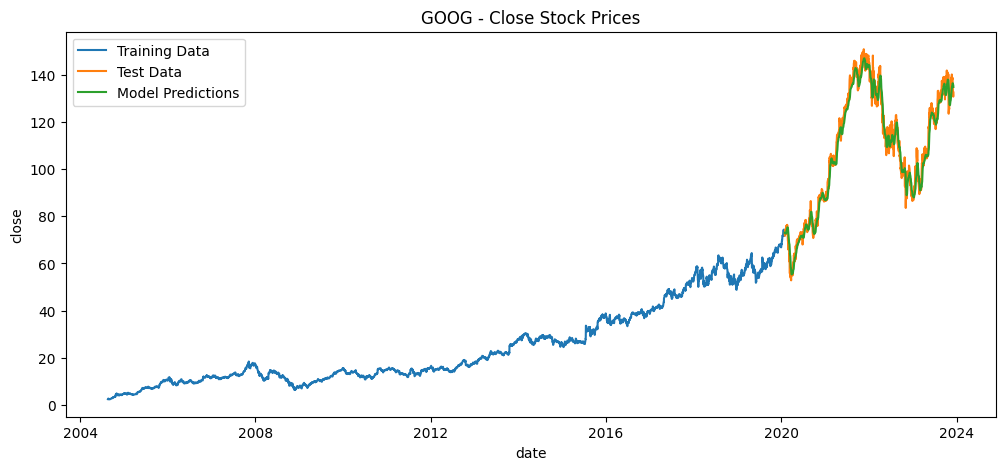

In [42]:
train = goog[:training_data_count]
test = goog[training_data_count:]
test['Predictions'] = predictions

plt.figure(figsize=(12, 5))
plt.plot(train['date'], train['close'])
plt.plot(test['date'], test[['close', 'Predictions']])
plt.title('GOOG - Close Stock Prices')
plt.xlabel('date')
plt.ylabel("close")
plt.legend(['Training Data', 'Test Data', 'Model Predictions'])